In [ ]:
pip install imgaug

In [262]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import cv2
from tqdm import tqdm
import random

start = time.time()

In [263]:
TRAIN_DIR_MildDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented'
TRAIN_DIR_ModerateDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/ModerateDemented'
TRAIN_DIR_NonDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/NonDemented'
TRAIN_DIR_VeryMildDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/VeryMildDemented'
TRAIN_DIR=[]
TRAIN_DIR.append(TRAIN_DIR_MildDemented)
TRAIN_DIR.append(TRAIN_DIR_ModerateDemented)
TRAIN_DIR.append(TRAIN_DIR_NonDemented)
TRAIN_DIR.append(TRAIN_DIR_VeryMildDemented)

TEST_DIR_MildDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented'
TEST_DIR_ModerateDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented'
TEST_DIR_NonDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/NonDemented'
TEST_DIR_VeryMildDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented'
TEST_DIR=[]
TEST_DIR.append(TEST_DIR_MildDemented)
TEST_DIR.append(TEST_DIR_ModerateDemented)
TEST_DIR.append(TEST_DIR_NonDemented)
TEST_DIR.append(TEST_DIR_VeryMildDemented)


dim = 150

test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
momentum = .9                 # momentum of SGD                                                     .9

train_images=[]
test_images=[]


In [ ]:
def augmentation(input_img):
    list_data=[]
    datagen = ImageDataGenerator(
        rotation_range=40, width_shift_range=0.2,
        height_shift_range=0.2,  shear_range=0.2,
        zoom_range=0.2, horizontal_flip=True,
        fill_mode='nearest')
    img = input_img
    i=0
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,)+x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    for batch in datagen.flow(x, batch_size=1):
        list_data.append(img_to_array(batch[0]))
        i += 1
        if i ==2:
            break 

    return list_data

In [264]:
def create_label_train(path):
    if TRAIN_DIR.index(path)==0:
        return np.array([1,0,0,0])
    if TRAIN_DIR.index(path)==1:
        return np.array([0,1,0,0])
    if TRAIN_DIR.index(path)==2:
        return np.array([0,0,1,0])
    if TRAIN_DIR.index(path)==3:
        return np.array([0,0,0,1])

def create_label_test(path):
    if TEST_DIR.index(path)==0:
        return np.array([1,0,0,0])
    if TEST_DIR.index(path)==1:
        return np.array([0,1,0,0])
    if TEST_DIR.index(path)==2:
        return np.array([0,0,1,0])
    if TEST_DIR.index(path)==3:
        return np.array([0,0,0,1])
   

In [265]:

def create_train_data():
    training_data = []

    for path_TRAIN_DIR in tqdm(TRAIN_DIR):
        for img in os.listdir(path_TRAIN_DIR):
            
            label=create_label_train(path_TRAIN_DIR)
            path = os.path.join(path_TRAIN_DIR, img)
            img_data = cv2.imread(path,1) 
            img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
            img_data = cv2.resize(img_data, (dim,dim))
           
            training_data.append([img_data,label])

    random.shuffle(training_data)

    return training_data


In [266]:
def create_test_data():
    test_data = []

    for path_Test_DIR in tqdm(TEST_DIR):
           for img in os.listdir(path_Test_DIR):
                
            label=create_label_test(path_Test_DIR)
            path = os.path.join(path_Test_DIR, img)
            img_data = cv2.imread(path,1) 
            img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
            img_data = cv2.resize(img_data, (dim,dim))
           
            test_data.append([ np.array(img_data),label ])
       

    #random.shuffle(test_data)
    return test_data

In [267]:
train_images = create_train_data()
X_train = np.array([i[0] for i in train_images])
y_train =[i[1] for i in train_images]

test_images = create_test_data()
X_test = np.array([i[0] for i in test_images])
y_test = [i[1] for i in test_images]

class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']

print(X_train.shape)
print(X_test.shape)


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

(5121, 150, 150, 3)
(1279, 150, 150, 3)


Text(0.5, 1.0, '[1 0 0 0]')

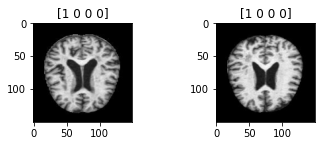

In [268]:
plt.subplot(221)
plt.imshow(X_train[1,:,:,:])
plt.title(y_train[1])

plt.subplot(222)
plt.imshow(X_test[1,:,:,:])
plt.title(y_test[1])

In [269]:
# cocatenate arrays, combining all data
total_data = np.concatenate((X_train,X_test))
total_labels = np.concatenate((y_train,y_test))
print(total_data.shape)
print(total_labels.shape)

(6400, 150, 150, 3)
(6400, 4)


In [270]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4479, 150, 150, 3)
validation (641, 150, 150, 3)
test (1280, 150, 150, 3)


In [271]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4479, 150, 150, 3)
(4479, 4)
(641, 150, 150, 3)
(641, 4)
(1280, 150, 150, 3)
(1280, 4)


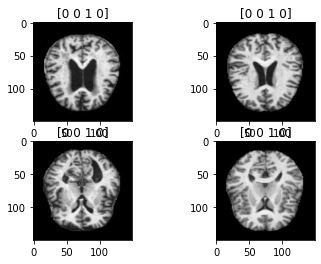

Text(0.5, 1.0, '[1 0 0 0]')

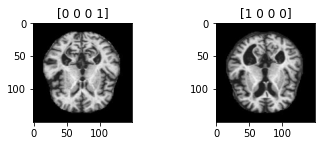

In [272]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.title(train_labels[7])
plt.subplot(222)

plt.imshow(train_data[150,:,:,:])
plt.title(train_labels[150])
plt.subplot(223)

plt.imshow(val_data[45,:,:,:])
plt.title(val_labels[45])
plt.subplot(224)

plt.imshow(val_data[4,:,:,:])
plt.title(val_labels[4])
plt.show()

plt.subplot(221)
plt.imshow(test_data[70,:,:,:])
plt.title(test_labels[70])

plt.subplot(222)
plt.imshow(test_data[140,:,:,:])
plt.title(test_labels[140])

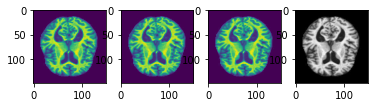

In [273]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

In [274]:
# import pre-trained VGG16 model

vg_model = tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet',input_shape=(150,150,3), pooling = 'max') #added pooling



In [275]:
## CHANGE MODEL STRUCTURE ##




## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
output = Dense(4,activation='softmax')(dp1)                                # changed to sigmoid from softmax
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0  

In [280]:
eps=30

In [277]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=momentum, nesterov=True,name='SGD') 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [278]:
# train the model
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                             epochs=30,batch_size=3, shuffle=True) #changed batch size from 15
scores = vg_model.evaluate(train_data, train_labels)
print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/30
1493/1493 [==============================] - 46s 30ms/step - loss: 1.2808 - accuracy: 0.4633 - val_loss: 0.9930 - val_accuracy: 0.5117
Epoch 2/30
1493/1493 [==============================] - 45s 30ms/step - loss: 0.9712 - accuracy: 0.5457 - val_loss: 0.9531 - val_accuracy: 0.5585
Epoch 3/30
1493/1493 [==============================] - 45s 30ms/step - loss: 0.9280 - accuracy: 0.5800 - val_loss: 0.8959 - val_accuracy: 0.5819
Epoch 4/30
1493/1493 [==============================] - 45s 30ms/step - loss: 0.9004 - accuracy: 0.5901 - val_loss: 0.9584 - val_accuracy: 0.5460
Epoch 5/30
1493/1493 [==============================] - 45s 30ms/step - loss: 0.8607 - accuracy: 0.6084 - val_loss: 0.8379 - val_accuracy: 0.6209
Epoch 6/30
1493/1493 [==============================] - 45s 30ms/step - loss: 0.8224 - accuracy: 0.6242 - val_loss: 0.8690 - val_accuracy: 0.5710
Epoch 7/30
1493/1493 [==============================] - 45s 30ms/step - loss: 0.7831 - accuracy: 0.6274 - val_loss: 0.7914 -

# Plots and Values

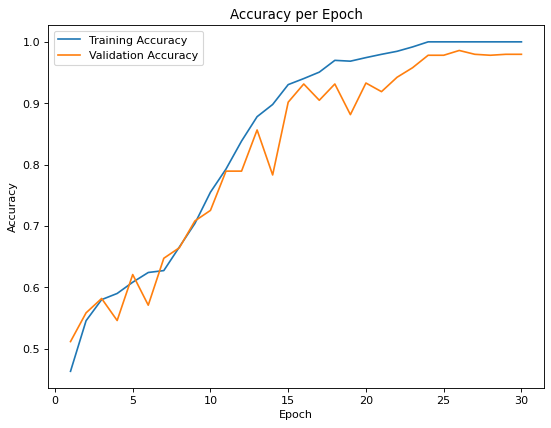

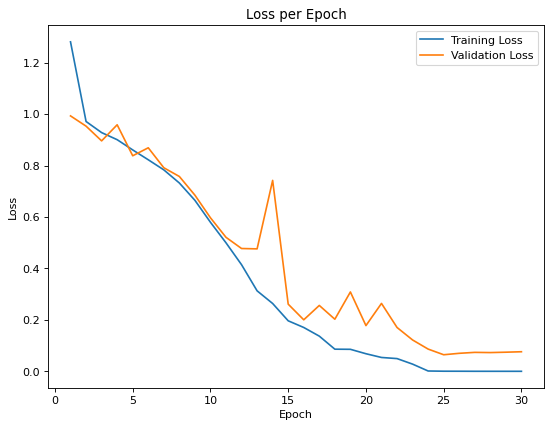

image dimensions:  150
validation split percentage:  0.2
epochs:  30
Model trained from scratch? :  True
Total Time Elapsed = 24 minutes


In [281]:
# plot accuracy

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Accuracy per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# print(np.amax.model_history.history['val_acc'])

#Plot loss
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Loss per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['loss'], label = 'Training Loss')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_loss'], label = 'Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# print out variable values
print('image dimensions: ',dim)
print('validation split percentage: ',validation_split_percent)
print('epochs: ',eps)
print('Model trained from scratch? : ',layers_unlocked)
end = time.time()
print('Total Time Elapsed = %.2d minutes'%((end - start)/60))

In [282]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

40/40 [==============================] - 2s 40ms/step - loss: 0.0596 - accuracy: 0.9859
Train Accuracy: 100.00%
Validation Accuracy: 97.97%
Test Accuracy: 98.59%


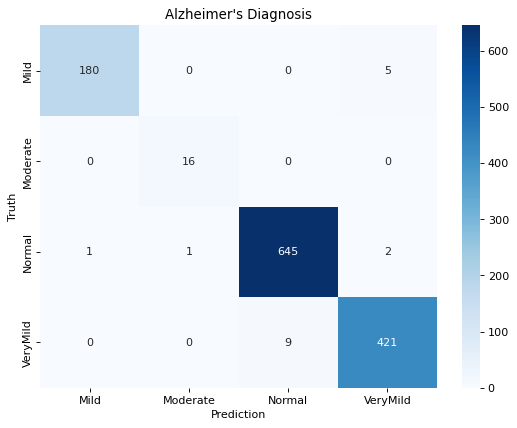

In [283]:
## CONFUSION MATRIX ##

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)


# Saving the Model

In [284]:
# ## saving in HDF5 format

vg_model.save('vgg19_epochs30_testacc98.h5')






# Load Model

In [ ]:


#vg_model = load_model("/kaggle/input/valsplit20-epochs50-testacc98h5/valsplit20_epochs50_testacc98.h5") 
